In [8]:
!pip install scikit-fuzzy
!pip install scikit-fuzzy numpy matplotlib

Green light duration: 30.00 seconds


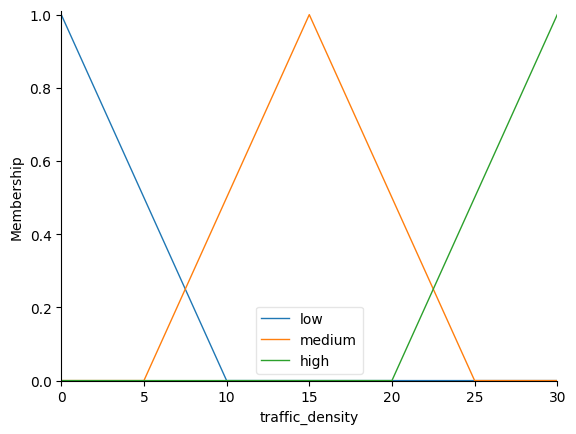

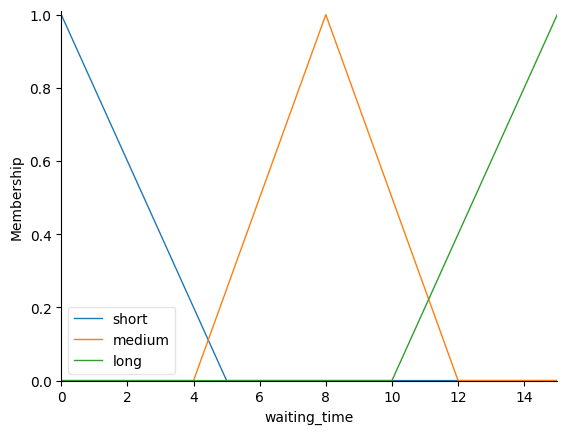

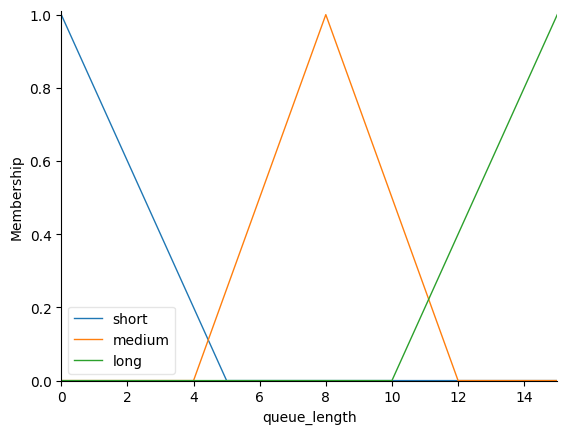

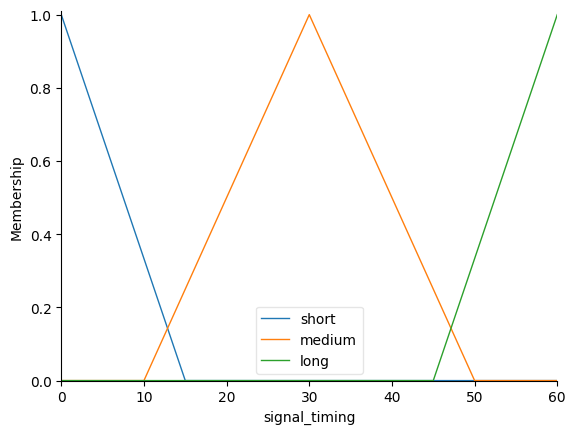

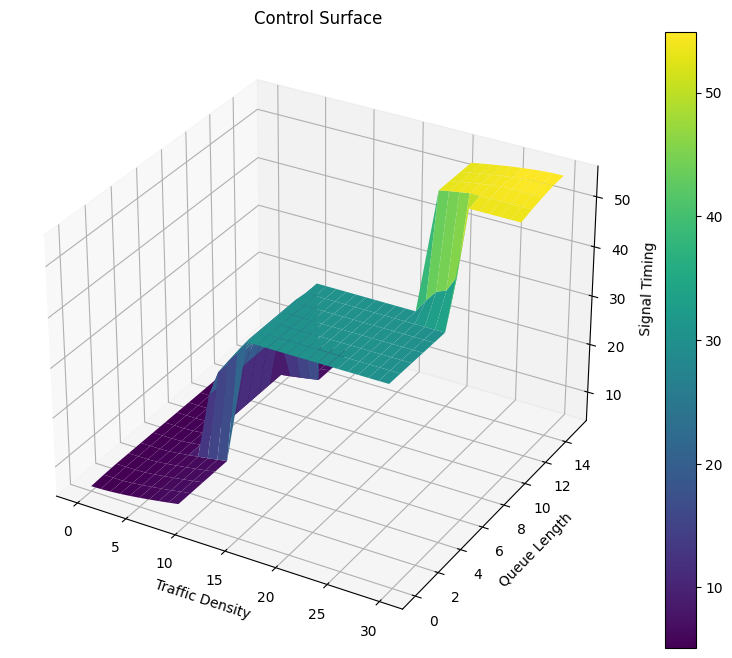

In [10]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Define the fuzzy variables for inputs
traffic_density = ctrl.Antecedent(np.arange(0, 31, 1), 'traffic_density')
waiting_time = ctrl.Antecedent(np.arange(0, 16, 1), 'waiting_time')
queue_length = ctrl.Antecedent(np.arange(0, 16, 1), 'queue_length')

# Define the fuzzy variable for output
signal_timing = ctrl.Consequent(np.arange(0, 61, 1), 'signal_timing')

# Define membership functions for traffic_density
traffic_density['low'] = fuzz.trimf(traffic_density.universe, [0, 0, 10])
traffic_density['medium'] = fuzz.trimf(traffic_density.universe, [5, 15, 25])
traffic_density['high'] = fuzz.trimf(traffic_density.universe, [20, 30, 30])

# Define membership functions for waiting_time
waiting_time['short'] = fuzz.trimf(waiting_time.universe, [0, 0, 5])
waiting_time['medium'] = fuzz.trimf(waiting_time.universe, [4, 8, 12])
waiting_time['long'] = fuzz.trimf(waiting_time.universe, [10, 15, 15])

# Define membership functions for queue_length
queue_length['short'] = fuzz.trimf(queue_length.universe, [0, 0, 5])
queue_length['medium'] = fuzz.trimf(queue_length.universe, [4, 8, 12])
queue_length['long'] = fuzz.trimf(queue_length.universe, [10, 15, 15])

# Define membership functions for signal_timing
signal_timing['short'] = fuzz.trimf(signal_timing.universe, [0, 0, 15])
signal_timing['medium'] = fuzz.trimf(signal_timing.universe, [10, 30, 50])
signal_timing['long'] = fuzz.trimf(signal_timing.universe, [45, 60, 60])

# Define fuzzy rules
rule1 = ctrl.Rule(traffic_density['high'] & queue_length['long'], signal_timing['long'])
rule2 = ctrl.Rule(traffic_density['medium'] & waiting_time['short'], signal_timing['medium'])
rule3 = ctrl.Rule(traffic_density['low'] & queue_length['short'], signal_timing['short'])
rule4 = ctrl.Rule(traffic_density['medium'] & queue_length['medium'], signal_timing['medium'])
rule5 = ctrl.Rule(traffic_density['low'] & waiting_time['medium'], signal_timing['short'])
rule6 = ctrl.Rule(traffic_density['high'] & waiting_time['long'], signal_timing['long'])

# Create control system
signal_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
signal_sim = ctrl.ControlSystemSimulation(signal_ctrl)

# Function to simulate traffic control system
def get_signal_timing(density, wait_time, queue_len):
    signal_sim.input['traffic_density'] = density
    signal_sim.input['waiting_time'] = wait_time
    signal_sim.input['queue_length'] = queue_len

    # Compute the result
    signal_sim.compute()

    return signal_sim.output['signal_timing']

# Example usage
current_density = 18  # Example traffic density
current_waiting_time = 7  # Example waiting time
current_queue_length = 8  # Example queue length

green_light_duration = get_signal_timing(current_density, current_waiting_time, current_queue_length)
print(f"Green light duration: {green_light_duration:.2f} seconds")

# Visualize the membership functions
traffic_density.view()
waiting_time.view()
queue_length.view()
signal_timing.view()

# Visualize the control surface
traffic_density_range = np.arange(0, 31, 1)
queue_length_range = np.arange(0, 16, 1)
x, y = np.meshgrid(traffic_density_range, queue_length_range)
# Initialize z with a float data type to accommodate np.nan
z = np.zeros_like(x, dtype=float)  # <-- Change here

for i in range(len(traffic_density_range)):
    for j in range(len(queue_length_range)):
        try:
            z[j, i] = get_signal_timing(traffic_density_range[i], current_waiting_time, queue_length_range[j])
        except ValueError:
            z[j, i] = np.nan

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='viridis')

ax.set_xlabel('Traffic Density')
ax.set_ylabel('Queue Length')
ax.set_zlabel('Signal Timing')
ax.set_title('Control Surface')

# Add color bar which maps values to colors.
fig.colorbar(surf)

plt.show()
